In [30]:
pdb_dir = "../datasets/casp16/R1203_newMXfold2_pdb/R1203_AF3_newMXfold2_FARFAR2"

from Bio import PDB
import numpy as np
import matplotlib.pyplot as plt
from Bio.PDB import PDBParser, Superimposer
from sklearn.manifold import MDS
import os
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# PDBファイルのリスト
pdb_files = [f for f in os.listdir(pdb_dir) if f.endswith('.pdb')]
# sort 
pdb_files.sort()

# RMSD計算用関数
def calculate_rmsd(file1, file2):
    parser = PDBParser()
    structure1 = parser.get_structure('X', os.path.join(pdb_dir, file1))
    structure2 = parser.get_structure('Y', os.path.join(pdb_dir, file2))
    
    atoms1 = [atom for atom in structure1.get_atoms()]
    atoms2 = [atom for atom in structure2.get_atoms()]
    
    sup = Superimposer()
    sup.set_atoms(atoms1, atoms2)
    sup.apply(atoms2)
    
    return sup.rms


def extract_scores(filename):
    import re
    
    scores = []
    with open(filename, 'r') as file:
        for line in file:
            if "SCORE:" in line:
                # スコアの部分を抽出して数値のリストに変換
                score_values = re.findall(r"[-+]?\d*\.\d+|\d+", line)
                scores.append([float(x) for x in score_values][1])
    return scores

# scores = extract_scores(os.path.join(pdb_dir, "scores.txt"))
# label = "FARFAR potential"
# print(scores)

df_scores = pd.read_csv(os.path.join(pdb_dir, "scores/energies_summary.csv"))
scores = df_scores["RNA_BRiQ"]
label = "RNA_BRiQ potential"


# RMSDマトリックスを計算
n = len(pdb_files)
rmsd_matrix = np.zeros((n, n))

def proc_get_rmsd(i_j):
    pdb_file_i, pdb_file_j = i_j
    rmsd = calculate_rmsd(pdb_file_i, pdb_file_j)
    return (pdb_file_i, pdb_file_j, rmsd)

# from multiprocessing import Pool
# from itertools import product
# import warnings
# warnings.filterwarnings('ignore')

# product_ij = product(pdb_files, pdb_files)
# with Pool(7) as p:
#     rmsd_matrix_list = p.map(proc_get_rmsd, product_ij)


In [33]:
n = 100
rmsd_matrix = np.zeros((n, n))

for i in range(n):
    print(i)
    for j in range(i + 1, n):
        rmsd = calculate_rmsd(pdb_files[i], pdb_files[j])
        rmsd_matrix[i, j] = rmsd
        rmsd_matrix[j, i] = rmsd


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


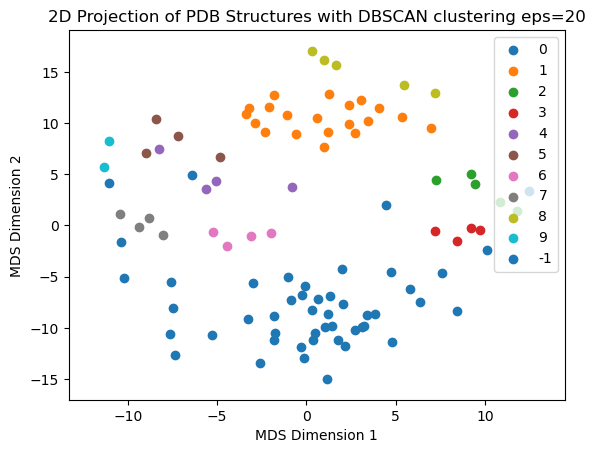

In [95]:
# MDSを使用して2Dにプロジェクト
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=42)
coords = mds.fit_transform(rmsd_matrix)

# kmeans clustering
from sklearn.cluster import DBSCAN, SpectralClustering
eps = 20
sc = DBSCAN(eps = eps, min_samples = 2)
sc.fit(rmsd_matrix)


# プロット with cluster label
plt.figure()
for c in set(sc.labels_):
    plt.scatter(coords[sc.labels_ == c, 0], coords[sc.labels_ == c, 1], label=c)
plt.legend()

# plt.scatter(coords[:, 0], coords[:, 1], c=sc.labels_, cmap='viridis')
# for i in range(n):
    # plt.text(coords[i, 0]-2, coords[i, 1]+0.5, os.path.splitext(pdb_files[i])[0], fontsize=9)
# for i in range(n):
#     plt.text(coords[i, 0]-2, coords[i, 1]+0.5, os.path.splitext(pdb_files[i])[0], fontsize=9)
plt.xlim(min(coords[:, 0])-2, max(coords[:, 0])+2)
plt.ylim(min(coords[:, 1])-2, max(coords[:, 1])+2)

# label = "RNA_BRiQ potential"
# plt.colorbar(label=label)
plt.xlabel('MDS Dimension 1')
plt.ylabel('MDS Dimension 2')
plt.title(f'2D Projection of PDB Structures with DBSCAN clustering eps={eps}')
plt.show()


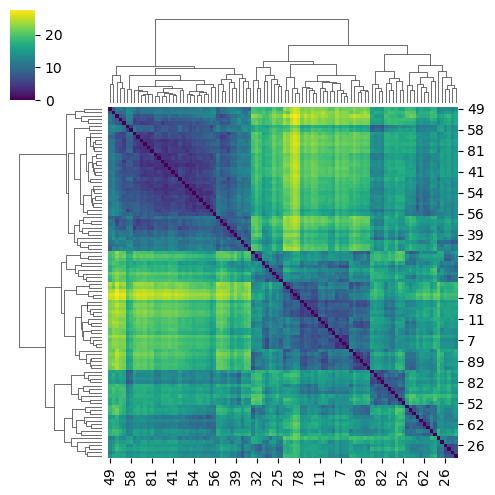

In [59]:
import seaborn as sns

# sns.clustermap(1/(rmsd_matrix+1), cmap='viridis')
sns.clustermap(rmsd_matrix, cmap='viridis', figsize=(5,5))

In [57]:
rmsd_matrix[:4, :4]

array([[ 0.        , 22.52435131, 19.36757411, 16.27834943],
       [22.52435131,  0.        , 14.31885694, 15.43073073],
       [19.36757411, 14.31885694,  0.        ,  6.93494696],
       [16.27834943, 15.43073073,  6.93494696,  0.        ]])

In [32]:
df_scores[df_scores["pdb"].isin(pdb_files[:4])]

,pdb,cgRNASP[kBT],cgRNASP-P[kBT],cgRNASP-PC[kBT],rsRNASP[kBT],RNA_BRiQ
0,S_000001.pdb,-1014.373399,-2078.203250,-534.481862,-16738.315502,-338.436
1,S_000002.pdb,-988.771542,-1984.217568,-527.729762,-16597.363465,-328.140
2,S_000003.pdb,-967.638324,-1895.551413,-516.148048,-15525.614836,-317.440
3,S_000004.pdb,-1007.475989,-2066.632658,-529.502440,-16496.305547,-323.598
